In [13]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [15]:
image = cv2.imread('sar_1 (1).jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 

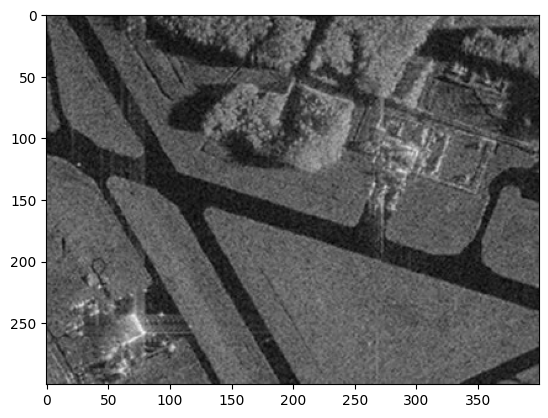

In [16]:
plt.imshow(image_gray, cmap="gray")

# Алгоритм разрастания регионов

In [17]:
import math
def homo_average(img, mask, point, T):
    av_val = img[mask > 0].sum() / np.count_nonzero(img[mask > 0])
                                                            
    if abs(av_val - img[point]) <= T:
        return True
    
    return False
    

In [18]:
def region_growing(image, seed_point,homo_fun,r, T):
    mask = np.zeros(image_gray.shape, np.uint8)
    mask[seed_point] = 1
    count = 1
    while count > 0:
        count = 0
        local_mask = np.zeros(image_gray.shape, np.uint8)
        for i in range(r,image.shape[0] - r):
            for j in range(r,image.shape[1] - r):
                if mask[i,j]==0 and mask[i - r:i + r, j-r: j+r].sum() > 0:
                    if homo_fun(image, mask, (i,j), T):
                        local_mask[i,j] = 1
        count = np.count_nonzero(local_mask)
        print(count)
        mask += local_mask
        
    return mask*255
    

In [19]:
seed_point = (250,250)
mask = region_growing(image_gray,seed_point,homo_average,1, 10)

3
4
4
5
7
6
6
9
7
6
6
9
13
12
15
17
13
13
16
16
14
16
15
16
10
11
14
13
14
10
10
14
17
15
36
22
21
18
21
21
25
23
43
31
34
23
20
27
29
35
40
32
35
42
48
52
30
23
20
19
19
20
18
22
74
24
26
29
30
27
29
29
28
29
20
17
17
21
20
25
23
24
20
18
19
15
18
18
15
18
13
10
9
7
9
9
10
11
12
10
12
11
8
9
7
4
3
6
6
6
5
5
5
3
2
2
2
1
0


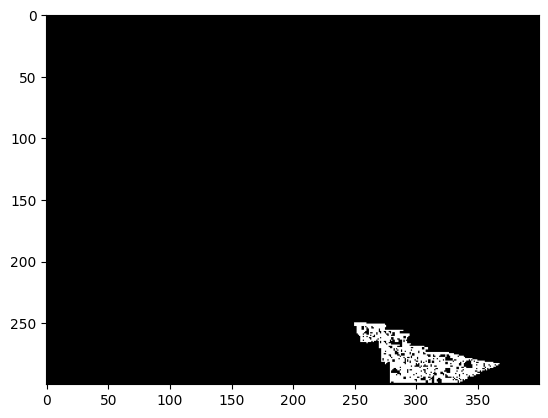

In [20]:
plt.imshow(mask, cmap="gray")

# K-means

In [21]:
# Define criteria = ( type, max_iter = 10 , epsilon = 1.0 )
# criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)

In [22]:
flags = cv2.KMEANS_RANDOM_CENTERS

In [23]:
z = image_gray.reshape((-1,3))
# convert to np.float32
z = np.float32(z)
# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 3
ret,label,center=cv2.kmeans(z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
# Now convert back into uint8, and make original image
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((image_gray.shape))

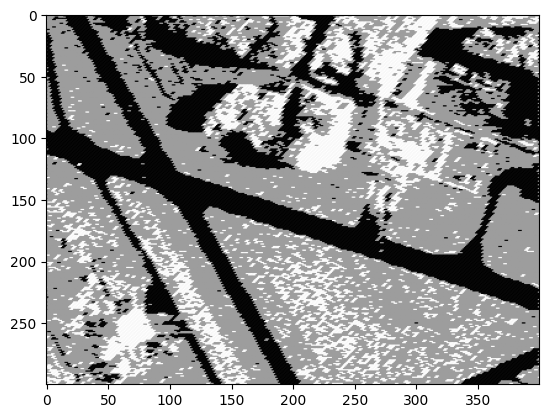

In [24]:
plt.imshow(res2, cmap="gray")

# Watershed+Distance transform

In [26]:
image = cv2.imread('oranges_1.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 

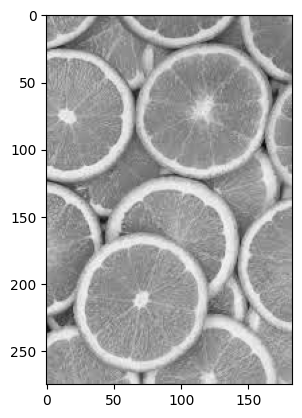

In [27]:
plt.imshow(image_gray, cmap="gray")

In [28]:
ret, thresh = cv2.threshold(image_gray,0,255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

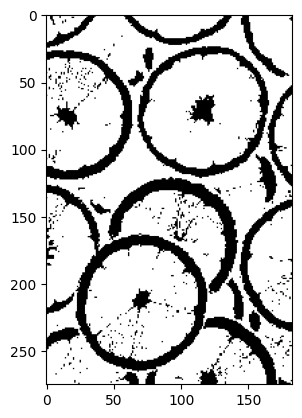

In [29]:
plt.imshow(thresh, cmap="gray")

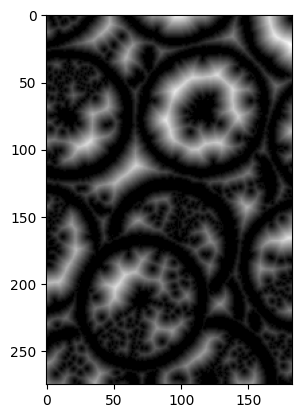

In [30]:
dist = cv2.distanceTransform(thresh, cv2.DIST_L2, 5) 
plt.imshow(dist, cmap="gray")

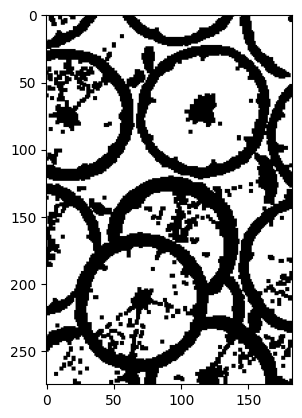

In [31]:
ret, sure_fg = cv2.threshold(dist, 0.1 * dist.max(), 255, cv2.THRESH_BINARY) 
plt.imshow(sure_fg, cmap="gray")

In [32]:
sure_fg = sure_fg.astype(np.uint8)

In [33]:
ret, markers = cv2.connectedComponents(sure_fg) 

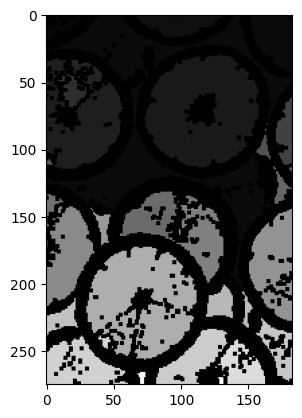

In [34]:
plt.imshow(markers, cmap="gray")

In [35]:
markers = cv2.watershed(image, markers)

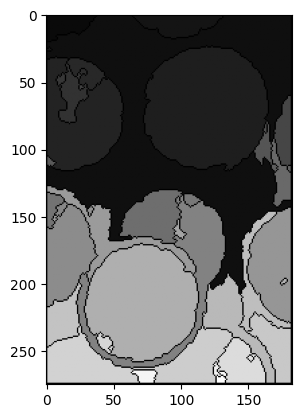

In [36]:
plt.imshow(markers, cmap="gray")

In [37]:
# ДЗ
# 1. Подберите парамтеры алгоритма разрастания регионов так, чтобы был выделен весь участок газона.
# 2. Реализуйте вычисление критерия однородности, отличного от представленного. Сравните результаты.
# 3. Применить алгоритм сегментации watershed+distance transform для задачи подсчета пальмовых деревьев.

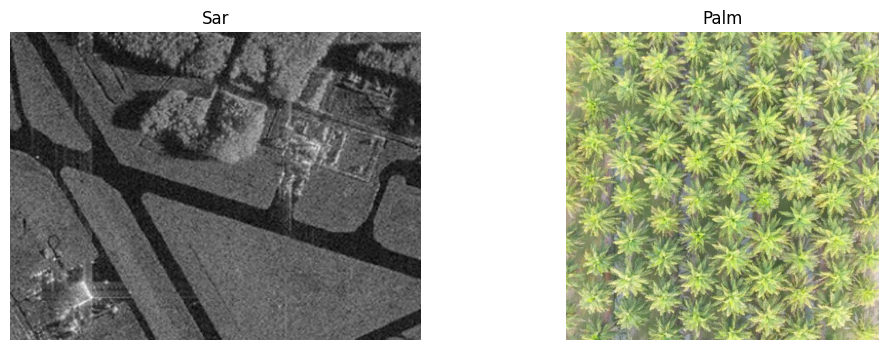

In [39]:
from skimage import io, color, filters, morphology, segmentation, feature, exposure, measure
from scipy import ndimage as ndi
from collections import deque
import numpy as np
import matplotlib.pyplot as plt

sar_path = cv2.imread("sar_1 (1).jpg")      
palm_path = cv2.imread("palm_1.jpg")     

sar = cv2.cvtColor(sar_path, cv2.COLOR_BGR2GRAY)
palm = cv2.cvtColor(palm_path, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12,4))

plt.subplot(1,2,1); 
plt.imshow(sar, cmap="gray"); 
plt.title("Sar"); 
plt.axis("off");

plt.subplot(1,2,2); 
plt.imshow(palm); 
plt.title("Palm");
plt.axis("off");

plt.show()

In [43]:
import math
image_gray = cv2.cvtColor(sar_path, cv2.COLOR_BGR2GRAY)

def homo_average(img, mask, point, T):
    av_val = img[mask > 0].sum() / np.count_nonzero(img[mask > 0])
                                                            
    if abs(av_val - img[point]) <= T:
        return True
    
    return False

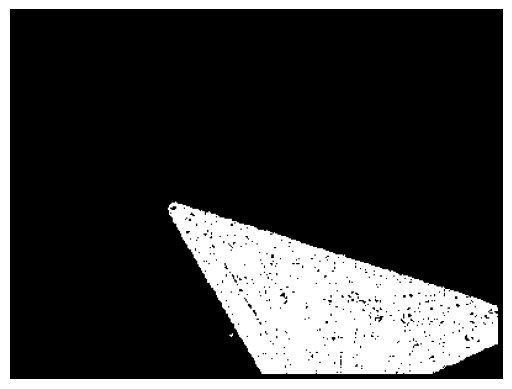

In [45]:
def region_growing(image, seed_point, homo_fun, r, T):
    mask = np.zeros(image.shape, np.uint8)
    mask[seed_point] = 1  
    count = 1
    while count > 0:
        count = 0
        local_mask = np.zeros(image.shape, np.uint8)
        for i in range(r, image.shape[0] - r):
            for j in range(r, image.shape[1] - r):
                if mask[i, j] == 0 and mask[i - r:i + r, j - r:j + r].sum() > 0:
                    if homo_fun(image, mask, (i, j), T):
                        local_mask[i, j] = 1
        count = np.count_nonzero(local_mask)
        mask += local_mask
    return mask * 255

seed_point = (250, 250)  

mask = region_growing(image_gray, seed_point, homo_average, 4, 18)

plt.imshow(mask, cmap="gray")
plt.axis("off");
plt.show()

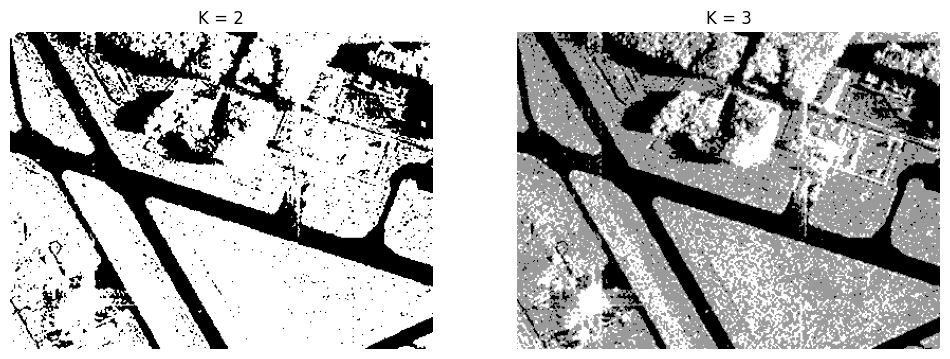

In [51]:
pixels = image_gray.reshape((-1, 1))
pixels = np.float32(pixels)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,10,1.0)

cluster_counts = [2, 3]  

plt.figure(figsize=(12, 5))

for i, k in enumerate(cluster_counts, start=1):
    _, labels, centers = cv2.kmeans(pixels, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    centers = np.uint8(centers)
    clustered = centers[labels.flatten()]
    clustered_image = clustered.reshape(gray.shape)

    plt.subplot(1, len(cluster_counts), i)
    plt.imshow(clustered_image, cmap="gray")
    plt.title(f"K = {k}")
    plt.axis("off")
plt.show()

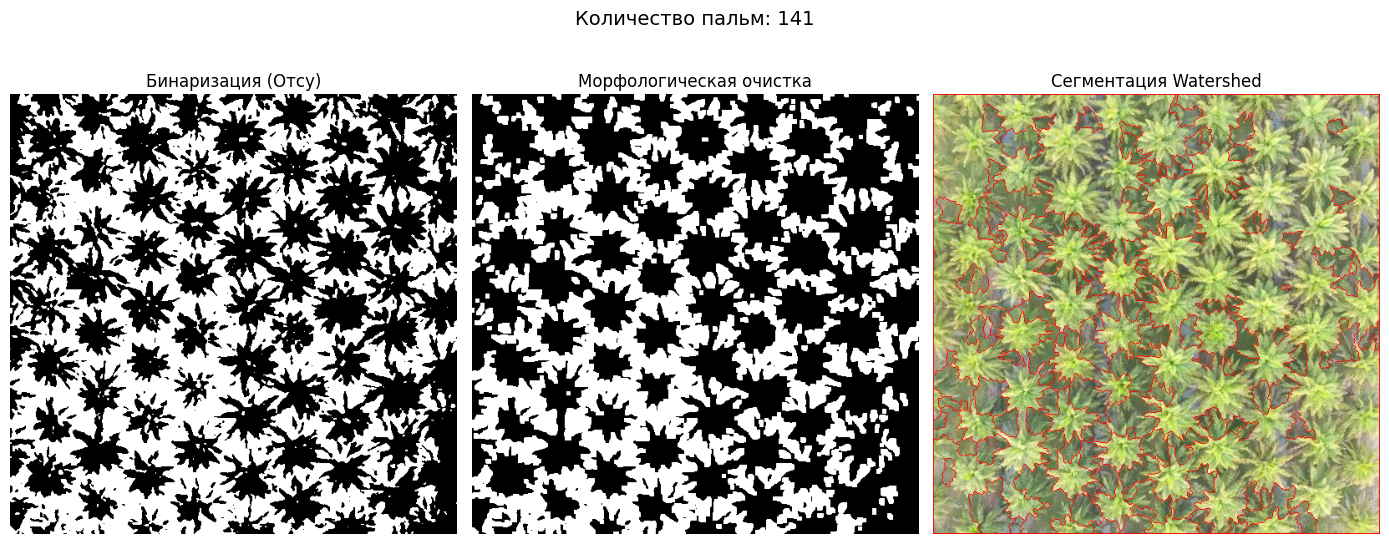

In [54]:
from scipy import ndimage as ndi

image_rgb = cv2.cvtColor(palm_path, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)

gray = cv2.equalizeHist(gray)

blurred = cv2.GaussianBlur(gray, (5, 5), 0)
_, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

kernel = np.ones((3, 3), np.uint8)
opened = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)
sure_bg = cv2.dilate(opened, kernel, iterations=3)

dist_transform = cv2.distanceTransform(opened, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist_transform, 0.45 * dist_transform.max(), 255, 0)
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

ret, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0
markers = cv2.watershed(image_rgb, markers)

result = image_rgb.copy()
result[markers == -1] = [255, 0, 0] 

num_trees = len(np.unique(markers)) - 2

plt.figure(figsize=(14, 6))

plt.subplot(1, 3, 1)
plt.imshow(binary, cmap="gray")
plt.title("Бинаризация (Отсу)")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(opened, cmap="gray")
plt.title("Морфологическая очистка")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(result)
plt.title("Сегментация Watershed")
plt.axis("off")

plt.suptitle(f"Количество пальм: {num_trees}", fontsize=14)
plt.tight_layout()
plt.show()